In [6]:
import os
import tensorflow as tf

tces_file = '../mnt/tess/astronet/tces-vetting-v02-train.csv'
file_pattern = '../mnt/tess/astronet/tfrecords-vetting-v02-train/*'
model_name = 'AstroCNNModelVetting'
config_name = 'base_new'
labels = ['p', 'e', 'n']
# tces_file = '../mnt/tess/astronet/tces-v14-test.csv'
# file_pattern = '../mnt/tess/astronet/tfrecords-38-test/*'
# model_name = 'AstroCNNModel'
# config_name = 'final_alpha_1'
# labels = ['E', 'N', 'J', 'S', 'B']

filenames = tf.io.gfile.glob(file_pattern)
    
filenames

['../mnt/tess/astronet/tfrecords-vetting-v02-train/00000-of-00005',
 '../mnt/tess/astronet/tfrecords-vetting-v02-train/00001-of-00005',
 '../mnt/tess/astronet/tfrecords-vetting-v02-train/00002-of-00005',
 '../mnt/tess/astronet/tfrecords-vetting-v02-train/00004-of-00005',
 '../mnt/tess/astronet/tfrecords-vetting-v02-train/00003-of-00005']

In [7]:
import pandas as pd

tce_table = pd.read_csv(tces_file, header=0, low_memory=False)
print(len(tce_table))
tce_table.head(3)

3212


,Astro ID,TIC ID,Final,Decision,Distinct,mk,ch,et,md,as,...,SRadEst,File,comment,disp_e,disp_p,disp_n,disp_b,disp_t,disp_u,disp_j
0,3358,393233743,et,NaN,1,et,et,NaN,NaN,NaN,...,2.450910,mk_hlsp_qlp_tess_ffi-s0020-0000000393233743_te...,EBs from TOI group vetting,1,0,0,0,1,0,0
1,1784,43770392,et,NaN,1,et,NaN,et,NaN,et,...,3.295305,mk_hlsp_qlp_tess_ffi-s0014-0000000043770392_te...,EBs from TOI group vetting,1,0,0,0,1,0,0
2,524,167651110,et,NaN,1,et,et,et,et,et,...,2.050283,mk_hlsp_qlp_tess_ffi-s0034-0000000167651110_te...,E labels from triage,1,0,0,0,1,0,0


In [8]:
series = {}

for filename in filenames:
  tfr = tf.data.TFRecordDataset(filename)
  num_records = 0
  for record in tfr:
    num_records += 1
    ex = tf.train.Example.FromString(record.numpy())
    for k in ex.features.feature.keys():
      f = ex.features.feature[k]
      if f.int64_list.value:
        v = f.int64_list.value[0]
      elif f.float_list.value:
        v = f.float_list.value[0]
      elif f.bytes_list.value:
        v = f.bytes_list.value[0].decode()
      else:
        continue

      if k not in series:
        series[k] = []
      series[k].append(v)
  print(filename, num_records)

2024-02-08 18:00:43.331615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-vetting-v02-train/00000-of-00005 642


2024-02-08 18:00:48.090285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-vetting-v02-train/00001-of-00005 642


2024-02-08 18:00:48.416922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-vetting-v02-train/00002-of-00005 643


2024-02-08 18:00:48.752228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-vetting-v02-train/00004-of-00005 643


2024-02-08 18:00:49.084914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-vetting-v02-train/00003-of-00005 642


In [9]:
import pandas as pd

examples_table = pd.DataFrame.from_dict(series)

pd.set_option('display.max_columns', None)
# examples_table[['secondary_scale']].describe()
examples_table.describe()

,local_view,local_aperture_l,local_scale_present,secondary_std,local_scale_present_0.3,local_std,global_view_double_period,star_mass_present,local_std_even,global_view_half_period_0.3,local_view_half_period_0.3,local_mask,secondary_view_0.3,global_view_double_period_mask_0.3,global_view_double_period_mask,local_aperture_m_0.3,global_view_0.3,astro_id,local_std_odd,local_view_odd,global_view_double_period_std_0.3,disp_p,local_std_odd_0.3,global_view_half_period,star_rad,disp_b,disp_e,global_view_double_period_mask_5.0,secondary_scale_5.0,global_mask_5.0,local_aperture_l_5.0,local_mask_odd,global_view_half_period_std,local_mask_5.0,disp_u,star_rad_est,local_view_half_period_5.0,local_view_half_period_std_5.0,global_view_half_period_5.0,secondary_view_5.0,local_view_odd_5.0,local_std_even_5.0,local_view_even_5.0,local_view_even,global_transit_mask_5.0,global_view_half_period_mask_0.3,secondary_scale_present_0.3,global_transit_mask,local_view_even_0.3,local_aperture_l_0.3,secondary_phase_5.0,global_mask_0.3,global_view_double_period_std,secondary_scale_present_5.0,n_points,secondary_phase_0.3,local_scale_present_5.0,secondary_std_0.3,local_mask_0.3,local_std_even_0.3,secondary_mask_0.3,local_aperture_m_5.0,local_mask_even_0.3,global_std_5.0,local_mask_odd_5.0,global_view,secondary_scale_present,secondary_mask_5.0,local_std_0.3,secondary_mask,Period,sample_segments_view,secondary_std_5.0,local_view_half_period_std,global_view_half_period_std_0.3,local_view_half_period_mask_0.3,local_view_half_period_mask,sample_segments_local_view_5.0,local_view_0.3,n_folds,local_mask_odd_0.3,secondary_phase,star_rad_present,disp_n,global_view_5.0,star_rad_est_present,global_view_double_period_5.0,local_view_half_period_std_0.3,local_mask_even,sample_segments_local_view_0.3,local_scale_0.3,local_scale,local_view_half_period,global_view_double_period_std_5.0,Duration,global_view_half_period_mask,local_view_half_period_mask_5.0,sample_segments_view_0.3,local_aperture_s_5.0,local_std_odd_5.0,Tmag,local_std_5.0,secondary_scale,local_view_5.0,Transit_Depth,global_mask,star_mass,local_aperture_m,sample_segments_view_5.0,global_view_half_period_std_5.0,local_aperture_s,local_aperture_s_0.3,disp_t,global_std_0.3,global_std,sample_segments_local_view,local_view_odd_0.3,global_view_double_period_0.3,global_transit_mask_0.3,local_scale_5.0,secondary_view,global_view_half_period_mask_5.0,disp_j,local_mask_even_5.0,secondary_scale_0.3
count,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.00000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.00000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3.212000e+03,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.0,3212.000000,3212.000000,3212.0,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.0,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.0,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.0,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.0,3212.0,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3.212000e+03,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.0,3212.000000,3212.000000,3212.0,3212.000000,3212.000000,3212.000000
mean,0.046045,0.048606,0.999689,0.280573,0.996264,0.276324,-0.066744,0.554795,0.258353,0.032335

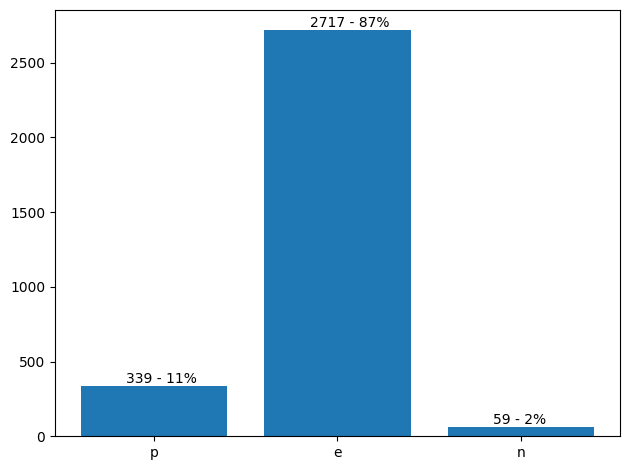

In [18]:
from matplotlib import pyplot as plt

counts = [sum(examples_table['disp_{}'.format(l)] > 0) for l in labels]
ax = plt.bar(labels, counts)
for i in range(len(labels)):
    b = ax[i]
    height = b.get_height()
    x, y = b.get_xy()
    plt.annotate(
        '{} - {:.0%}'.format(counts[i], counts[i] / sum(counts)),
        (x + 0.25, y + height + 20))
plt.tight_layout()

In [19]:
examples_table.head(3)

,local_view,local_aperture_l,local_scale_present,secondary_std,local_scale_present_0.3,local_std,global_view_double_period,star_mass_present,local_std_even,global_view_half_period_0.3,local_view_half_period_0.3,local_mask,secondary_view_0.3,global_view_double_period_mask_0.3,global_view_double_period_mask,local_aperture_m_0.3,global_view_0.3,astro_id,local_std_odd,local_view_odd,global_view_double_period_std_0.3,disp_p,local_std_odd_0.3,global_view_half_period,star_rad,disp_b,disp_e,global_view_double_period_mask_5.0,secondary_scale_5.0,global_mask_5.0,local_aperture_l_5.0,local_mask_odd,global_view_half_period_std,local_mask_5.0,disp_u,star_rad_est,local_view_half_period_5.0,local_view_half_period_std_5.0,global_view_half_period_5.0,secondary_view_5.0,local_view_odd_5.0,local_std_even_5.0,local_view_even_5.0,local_view_even,global_transit_mask_5.0,global_view_half_period_mask_0.3,secondary_scale_present_0.3,global_transit_mask,local_view_even_0.3,local_aperture_l_0.3,secondary_phase_5.0,global_mask_0.3,global_view_double_period_std,secondary_scale_present_5.0,n_points,secondary_phase_0.3,local_scale_present_5.0,secondary_std_0.3,local_mask_0.3,local_std_even_0.3,secondary_mask_0.3,local_aperture_m_5.0,local_mask_even_0.3,global_std_5.0,local_mask_odd_5.0,global_view,secondary_scale_present,secondary_mask_5.0,local_std_0.3,secondary_mask,Period,sample_segments_view,secondary_std_5.0,local_view_half_period_std,global_view_half_period_std_0.3,local_view_half_period_mask_0.3,local_view_half_period_mask,sample_segments_local_view_5.0,local_view_0.3,n_folds,local_mask_odd_0.3,secondary_phase,star_rad_present,disp_n,global_view_5.0,star_rad_est_present,global_view_double_period_5.0,local_view_half_period_std_0.3,local_mask_even,sample_segments_local_view_0.3,local_scale_0.3,local_scale,local_view_half_period,global_view_double_period_std_5.0,Duration,global_view_half_period_mask,local_view_half_period_mask_5.0,sample_segments_view_0.3,local_aperture_s_5.0,local_std_odd_5.0,Tmag,local_std_5.0,secondary_scale,local_view_5.0,Transit_Depth,global_mask,star_mass,local_aperture_m,sample_segments_view_5.0,global_view_half_period_std_5.0,local_aperture_s,local_aperture_s_0.3,disp_t,global_std_0.3,global_std,sample_segments_local_view,local_view_odd_0.3,global_view_double_period_0.3,global_transit_mask_0.3,local_scale_5.0,secondary_view,global_view_half_period_mask_5.0,disp_j,local_mask_even_5.0,secondary_scale_0.3
0,-0.016951,-0.016339,1.0,0.026444,1.0,0.037261,-0.027608,1.0,0.035620,-0.022173,0.009341,1.0,0.010311,1.0,1.0,-0.002387,0.013437,3358,0.037774,-0.023419,0.030280,0,0.030885,-0.014446,2.61805,0,1,1.0,0.000451,1.0,-0.012068,1.0,0.075283,1.0,0,2.450910,0.012167,0.159686,-0.028939,0.041081,0.001520,0.114684,-0.044036,-0.011561,0.0,1.0,1.0,0.0,-0.008857,-0.001201,0.843240,1.0,0.012916,1.0,1000.0,0.374790,1.0,0.031457,1.0,0.025159,1.0,-0.011988,1.0,0.059789,1.0,-0.012818,1.0,1.0,0.028622,1.0,1.923940,1.000192,0.089427,0.085332,0.060572,1.0,1.0,0.999499,-0.002387,26.0,1.0,0.670937,1.0,0,-0.016539,1.0,-0.033919,0.081503,1.0,0.999841,0.008537,0.008420,-0.001550,0.051144,0.103594,1.0,1.0,1.000185,-0.010967,0.017724,9.27638,0.043929,0.000293,-0.011988,8768.966797,1.0,1.496,-0.016951,0.999828,0.157440,-0.017576,-0.003517,1,0.033761,0.029647,0.999804,0.005377,0.002009,0.0,0.008261,-0.016540,1.0,0,1.0,0.000228
1,0.005405,0.007059,1.0,0.006376,1.0,0.003322,0.000000,1.0,0.001550,-0.001457,0.003217,1.0,-0.002521,0.0,0.0,0.001379,0.006993,1784,0.004424,0.005276,0.000000,0,0.004354,-0.001220,3.25479,0,1,0.0,0.000853,1.0,0.014207,1.0,0.006554,1.0,0,3.295305,0.010635,0.006713,0.003552,-0.010377,0.008438,0.001415,0.016769,0.005534,0.0,1.0,1.0,0.0,0.000976,0.002095,0.145046,1.0,0.000000,1.0,880.0,0.499072,1.0,0.000678,1.0,0.002056,1.0,0.012604,1.0,0.000111,1.0,0.006053,1.0,1.0,0.003508,1.0,10.036970,0.000000,0.000914,0.005570,0.007835,1.0,1.0,0.000000,0.001379,7.0,1.0,0.853097,1.0,0,-0.007438,1.0,0.000000,0.005619,1.0,0.000000,0.023693,0.025069,0.00510

In [20]:
tce_table[tce_table.index == 8209]

,Astro ID,TIC ID,Final,Decision,Distinct,mk,ch,et,md,as,dm,Tansu,Shishir,Astronet note,"Seed randbetween(1, 100)",Split,RA,Dec,Tmag,Epoc,Per,Dur,Depth,Sectors,SRad,SMass,teff,logg,SN,Qingress,SRadEst,File,comment,disp_e,disp_p,disp_n,disp_b,disp_t,disp_u,disp_j


In [21]:
import numpy as np

print('Label mismtaches between TCE and tfrecords:')
np.array(set(tce_table[tce_table[f'disp_{labels[0]}'] > 0]['Astro ID'].values)
    - set(examples_table[examples_table[f'disp_{labels[0]}'] > 0]['astro_id'].values))

Label mismtaches between TCE and tfrecords:


array(set(), dtype=object)

In [22]:
import tensorflow as tf

from astronet import models
from astronet.astro_cnn_model import input_ds

config = models.get_model_config(model_name, config_name)

ds = input_ds.build_dataset(
      file_pattern=file_pattern,
      input_config=config.inputs,
      batch_size=1,
      include_labels=False,
      shuffle_filenames=False,
      repeat=1,
      include_identifiers=True)
labels_ds = input_ds.build_dataset(
      file_pattern=file_pattern,
      input_config=config.inputs,
      batch_size=1,
      include_labels=True,
      shuffle_filenames=False,
      repeat=1,
      include_identifiers=True)
labels_iter = iter(labels_ds)

label_index = {k.lower(): i for i, k in enumerate(config.inputs.label_columns)}
cols = [f"disp_{l}" for l in labels]  # ["disp_E", "disp_N", "disp_J", "disp_S", "disp_B"]


all_ids = []
bad_labels = []
for d in ds:
  lab = next(labels_iter)
  
  def lam(e):
    if e.dtype == tf.int64:
        return e
    if tf.reduce_any(tf.math.is_nan(e)):
        tf.print(e, summarize=-1)
        raise ValueError('data has NaNs.')
    return e
  ex_id = d[1].numpy().item()
  all_ids.append(ex_id)
  
  assert lab[0]['duration'] == d[0]['duration']
  rec = tce_table[tce_table['Astro ID'] == ex_id]
  for c in cols:
    if (lab[1][0][label_index[c.lower()]].numpy() == 0) != (rec[c].values[0] == 0):
      bad_labels.append(ex_id)
      print('bad example: ', ex_id)
      print(rec)
      print(cols)
      print(lab[1][0])
      break
  if bad_labels:
    break
  
  try:
    tf.nest.map_structure(lam, d)
  except ValueError as e:
    print(e)
    print(d[1])
    break
else:
  print('No NaNs or mismtached labels found.')

if len(all_ids) == len(set(all_ids)):
  print('No duplicates found.')
else:
  print('Found duplicates!', len(all_ids) - len(set(all_ids)))
  print([t for t in set(all_ids) if all_ids.count(t) > 1])

2024-02-08 18:01:46.319000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]
2024-02-08 18:01:46.408649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]


No NaNs or mismtached labels found.
No duplicates found.


In [24]:
def astro_id(tic_id):
  return tce_table[tce_table['TIC ID'] == tic_id]['Astro ID'].values[0]

In [25]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from astronet.preprocess import preprocess


tess_data_dir = '../mnt/tess/lc'

def find_tce(astro_id):
  with tf.device('cpu'):
    for filename in filenames:
      tfr = tf.data.TFRecordDataset(filename)
      for record in tfr:
        ex = tf.train.Example.FromString(record.numpy())
        if (ex.features.feature["astro_id"].int64_list.value[0] == astro_id):
          print('TIC ID:', tic_id)
          for l in labels:
              print(f'{l}:', ex.features.feature[f"disp_{l}"].int64_list.value[0])
          print('Duration:', ex.features.feature["Duration"].float_list.value[0])
          return ex

    raise ValueError("{} not found in files: {}".format(astro_id, filenames))

In [26]:
ds = ds.cache()
def plot_ds_tce(ds, astro_id):
    for d in ds:
        if d[1] == astro_id:
            for k, v in d[0].items():
                if k.startswith('local_'):
                    continue
                if k.startswith('global_'):
                    continue
                if k.startswith('secondary_'):
                    continue
                if k.startswith('sample_'):
                    continue
                print(f'{k:25}: {v.numpy()}')
            global_view = np.array(d[0]['global_view'][0].numpy())
            local_view = np.array(d[0]['local_view'][0].numpy())
            secondary_view = np.array(d[0]['secondary_view'][0].numpy())
            fig, axes = plt.subplots(2, 3, figsize=(20, 12))
            axes[0, 0].plot(global_view, '.-')
            axes[0, 1].plot(local_view, '.-')
            axes[0, 2].plot(secondary_view, '.-')
            axes[1, 0].plot(d[0]['global_mask'][0].numpy(), '.-')
            axes[1, 1].plot(d[0]['global_view_0.3'][0].numpy(), '.-')
            axes[1, 2].plot(d[0]['global_view_5.0'][0].numpy(), '.-')
            plt.show()
            plt.close('all')
            return

In [27]:
ds

<CacheDataset element_spec=({'duration': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'period': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'tmag': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'transit_depth': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'global_mask': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_std': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_transit_mask': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_0.3': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_5.0': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_double_period': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_double_period_0.3': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_double_period_5.0': TensorSpec(s

duration                 : [[-0.03010806]]
period                   : [[0.21632543]]
tmag                     : [[0.7161043]]
transit_depth            : [[0.2314925]]
n_folds                  : [[0.75925696]]
star_mass                : [[0.29319498]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.56831986]]
star_rad_est             : [[-0.22630557]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


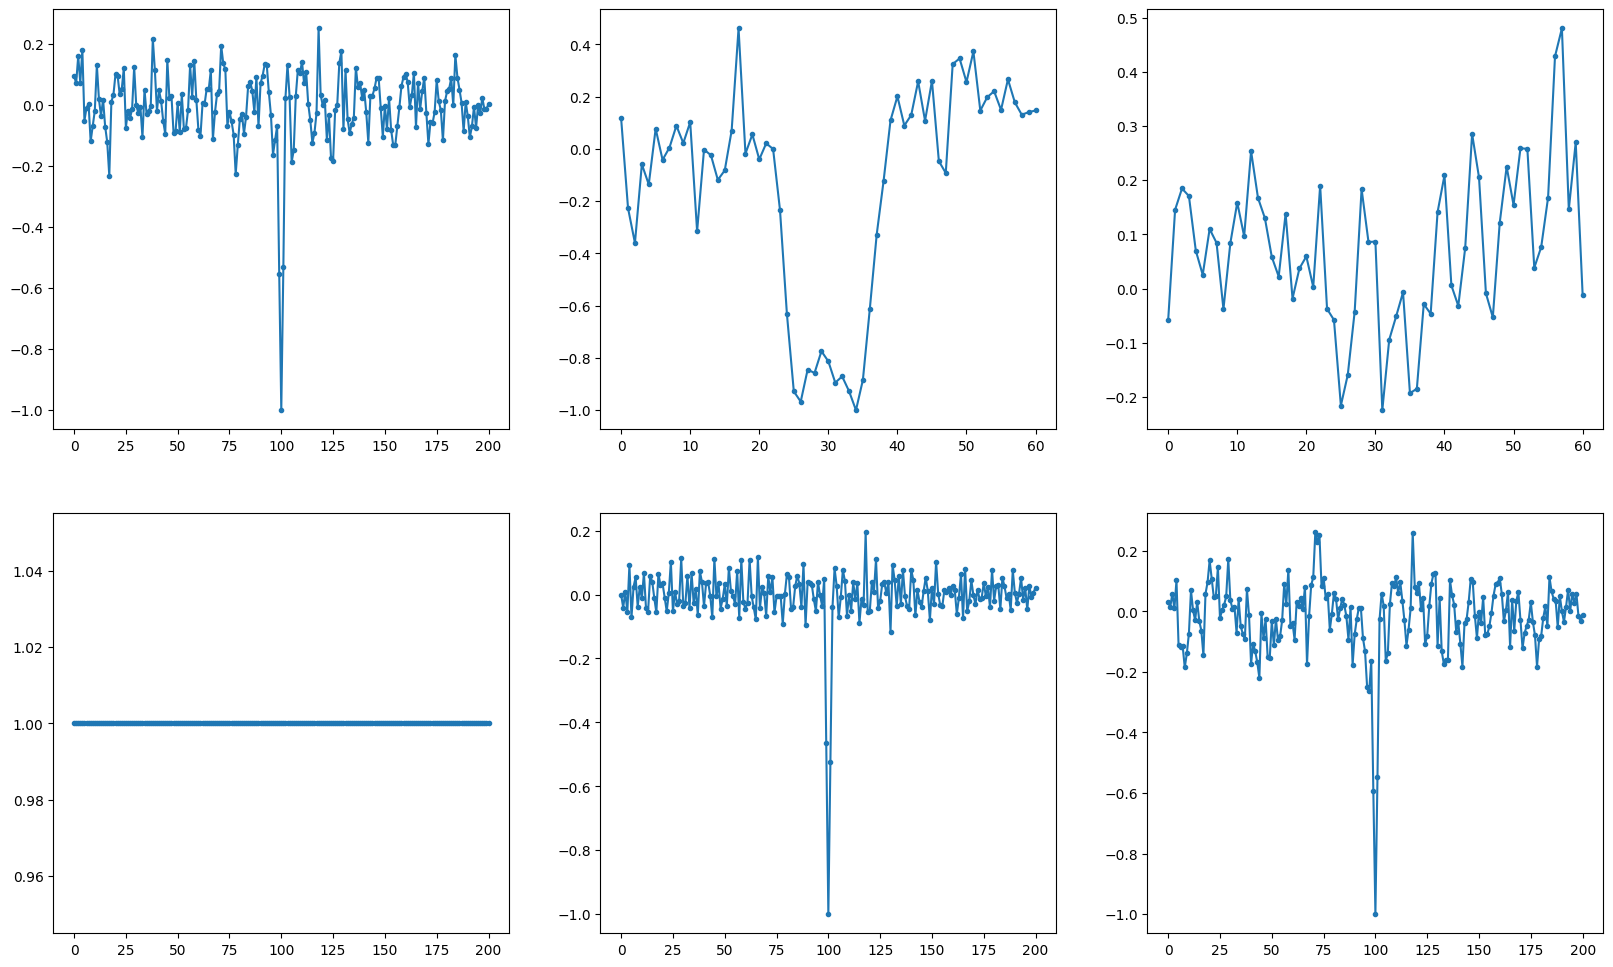

2024-02-08 18:05:53.004625: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [30]:
tic_id = 314865962
plot_ds_tce(ds, astro_id(tic_id))

In [31]:
tce_table[tce_table['TIC ID'] == tic_id]

,Astro ID,TIC ID,Final,Decision,Distinct,mk,ch,et,md,as,dm,Tansu,Shishir,Astronet note,"Seed randbetween(1, 100)",Split,RA,Dec,Tmag,Epoc,Per,Dur,Depth,Sectors,SRad,SMass,teff,logg,SN,Qingress,SRadEst,File,comment,disp_e,disp_p,disp_n,disp_b,disp_t,disp_u,disp_j
3209,1069,314865962,pt,pt,2,pt,pu,pt,pt,pt,NaN,NaN,NaN,NaN,11.0,val,53.281311,-72.744243,10.3539,1335.941311,22.463614,0.24098,480.616966,NaN,0.978381,0.98,5548.0,4.44828,NaN,NaN,0.970018,mk_hlsp_qlp_tess_ffi-s0033-0000000314865962_te...,E labels from triage,0,1,0,0,1,0,0


In [32]:
astro_id(tic_id)

1069

In [33]:
examples_table[examples_table['astro_id'] == astro_id(tic_id)]

,local_view,local_aperture_l,local_scale_present,secondary_std,local_scale_present_0.3,local_std,global_view_double_period,star_mass_present,local_std_even,global_view_half_period_0.3,local_view_half_period_0.3,local_mask,secondary_view_0.3,global_view_double_period_mask_0.3,global_view_double_period_mask,local_aperture_m_0.3,global_view_0.3,astro_id,local_std_odd,local_view_odd,global_view_double_period_std_0.3,disp_p,local_std_odd_0.3,global_view_half_period,star_rad,disp_b,disp_e,global_view_double_period_mask_5.0,secondary_scale_5.0,global_mask_5.0,local_aperture_l_5.0,local_mask_odd,global_view_half_period_std,local_mask_5.0,disp_u,star_rad_est,local_view_half_period_5.0,local_view_half_period_std_5.0,global_view_half_period_5.0,secondary_view_5.0,local_view_odd_5.0,local_std_even_5.0,local_view_even_5.0,local_view_even,global_transit_mask_5.0,global_view_half_period_mask_0.3,secondary_scale_present_0.3,global_transit_mask,local_view_even_0.3,local_aperture_l_0.3,secondary_phase_5.0,global_mask_0.3,global_view_double_period_std,secondary_scale_present_5.0,n_points,secondary_phase_0.3,local_scale_present_5.0,secondary_std_0.3,local_mask_0.3,local_std_even_0.3,secondary_mask_0.3,local_aperture_m_5.0,local_mask_even_0.3,global_std_5.0,local_mask_odd_5.0,global_view,secondary_scale_present,secondary_mask_5.0,local_std_0.3,secondary_mask,Period,sample_segments_view,secondary_std_5.0,local_view_half_period_std,global_view_half_period_std_0.3,local_view_half_period_mask_0.3,local_view_half_period_mask,sample_segments_local_view_5.0,local_view_0.3,n_folds,local_mask_odd_0.3,secondary_phase,star_rad_present,disp_n,global_view_5.0,star_rad_est_present,global_view_double_period_5.0,local_view_half_period_std_0.3,local_mask_even,sample_segments_local_view_0.3,local_scale_0.3,local_scale,local_view_half_period,global_view_double_period_std_5.0,Duration,global_view_half_period_mask,local_view_half_period_mask_5.0,sample_segments_view_0.3,local_aperture_s_5.0,local_std_odd_5.0,Tmag,local_std_5.0,secondary_scale,local_view_5.0,Transit_Depth,global_mask,star_mass,local_aperture_m,sample_segments_view_5.0,global_view_half_period_std_5.0,local_aperture_s,local_aperture_s_0.3,disp_t,global_std_0.3,global_std,sample_segments_local_view,local_view_odd_0.3,global_view_double_period_0.3,global_transit_mask_0.3,local_scale_5.0,secondary_view,global_view_half_period_mask_5.0,disp_j,local_mask_even_5.0,secondary_scale_0.3
2567,0.11708,0.145571,1.0,0.623956,1.0,0.697678,-0.018083,1.0,0.673137,-0.074104,0.231539,1.0,-0.016642,1.0,1.0,0.140545,0.0,1069,0.71745,0.0738,0.843457,1,0.522347,-0.100192,0.978381,0,0,1.0,0.000203,1.0,0.147605,1.0,1.480818,1.0,0,0.970018,0.168411,1.396614,-0.069715,0.112919,0.196665,0.713158,0.070067,0.167545,0.0,1.0,1.0,0.0,0.275157,0.18598,0.864885,1.0,0.868297,1.0,21607.0,0.819829,1.0,0.510658,1.0,0.551581,1.0,0.138218,1.0,0.709372,1.0,0.096146,1.0,1.0,0.547717,1.0,22.463614,0.999961,0.989926,1.309888,1.385268,1.0,1.0,1.000505,0.140545,32.0,1.0,0.583822,1.0,0,0.029915,1.0,-0.181992,1.134928,1.0,1.000474,0.000912,0.000744,0.102603,0.743763,0.24098,1.0,1.0,1.000014,0.133496,0.769912,10.3539,0.749103,0.000224,0.138218,480.616974,1.0,0.98,0.11708,1.000291,1.426843,0.123759,0.118504,1,0.674287,0.748839,1.000381,0.025102,-0.05435,0.0,0.000725,-0.058025,1.0,0,1.0,0.000207


In [34]:
!ls ../mnt/tess/lc | grep 322117652

mk_hlsp_qlp_tess_ffi-s0011-0000000322117652_tess_v01_llc.fits


In [35]:
tic_id = 314865962
tce = find_tce(astro_id(tic_id))

list(tce.features.feature.keys())

2024-02-08 18:05:58.967345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-02-08 18:05:59.164916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-02-08 18:05:59.279417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{n

TIC ID: 314865962
p: 1
e: 0
n: 0
Duration: 0.24098041653633118


['local_view',
 'local_aperture_l',
 'local_scale_present',
 'secondary_std',
 'local_scale_present_0.3',
 'local_std',
 'global_view_double_period',
 'star_mass_present',
 'local_std_even',
 'global_view_half_period_0.3',
 'local_view_half_period_0.3',
 'local_mask',
 'secondary_view_0.3',
 'global_view_double_period_mask_0.3',
 'global_view_double_period_mask',
 'local_aperture_m_0.3',
 'global_view_0.3',
 'astro_id',
 'local_std_odd',
 'local_view_odd',
 'global_view_double_period_std_0.3',
 'disp_p',
 'local_std_odd_0.3',
 'global_view_half_period',
 'star_rad',
 'disp_b',
 'disp_e',
 'global_view_double_period_mask_5.0',
 'secondary_scale_5.0',
 'global_mask_5.0',
 'local_aperture_l_5.0',
 'local_mask_odd',
 'global_view_half_period_std',
 'local_mask_5.0',
 'disp_u',
 'star_rad_est',
 'local_view_half_period_5.0',
 'local_view_half_period_std_5.0',
 'global_view_half_period_5.0',
 'secondary_view_5.0',
 'local_view_odd_5.0',
 'local_std_even_5.0',
 'local_view_even_5.0',
 'local_